# Introducing: HistFrames Plotting

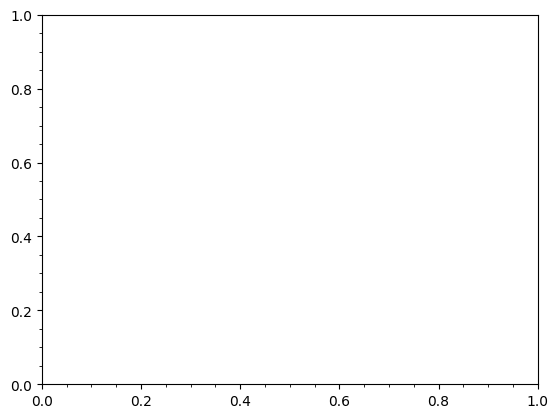

In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
pn.cern()

We can then add an entry to a bin

In [2]:
bf2 = pn.BinnedValues(pn.Binning.lin_space(0,10,5), "MCPrediction")
bf2.values = [[0.5,0.5,0.1,0.1,0.1]]
print(bf2.values)
bf2.make_HistFrame()


[[0.5 0.5 0.1 0.1 0.1]]


 ----------------------------
 | bin | MCPrediction | err |
 ----------------------------
 |   0 |            0 |   0 |
 |   1 |            0 |   0 |
 |   2 |            0 |   0 |
 |   3 |            0 |   0 |
 |   4 |            0 |   0 |
 ----------------------------

In [3]:
import pyProSelecta as pps
evs = pn.EventSource("../../runs/NUWRO-D2-ANL_77-numu/NUWRO.numu.numu_flux.ANL_1977_2horn_rescan.8652.evts.root")
if not evs:
    print("Error: failed to open input file")

def enu_GeV(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.HistFrame.missing_datum
    return bpart.momentum().e() * 1E-3

def q0(ev):
    bpart = pps.sel.Beam(ev,14)
    lpart = pps.sel.OutPartHM(ev,13)
    if not bpart or not lpart:
        return 0 #pn.HistFrame.missing_datum
    return ((bpart.momentum() - lpart.momentum()).e() ) / 1e3

def q3(ev):
    bpart = pps.sel.Beam(ev,14)
    lpart = pps.sel.OutPartHM(ev,13)
    if not bpart or not lpart:
        return 0 #pn.HistFrame.missing_datum
    return (bpart.momentum() - lpart.momentum()).length() / 1e3
    


Lets make a more sensibly binned histogram and fill it with a few events

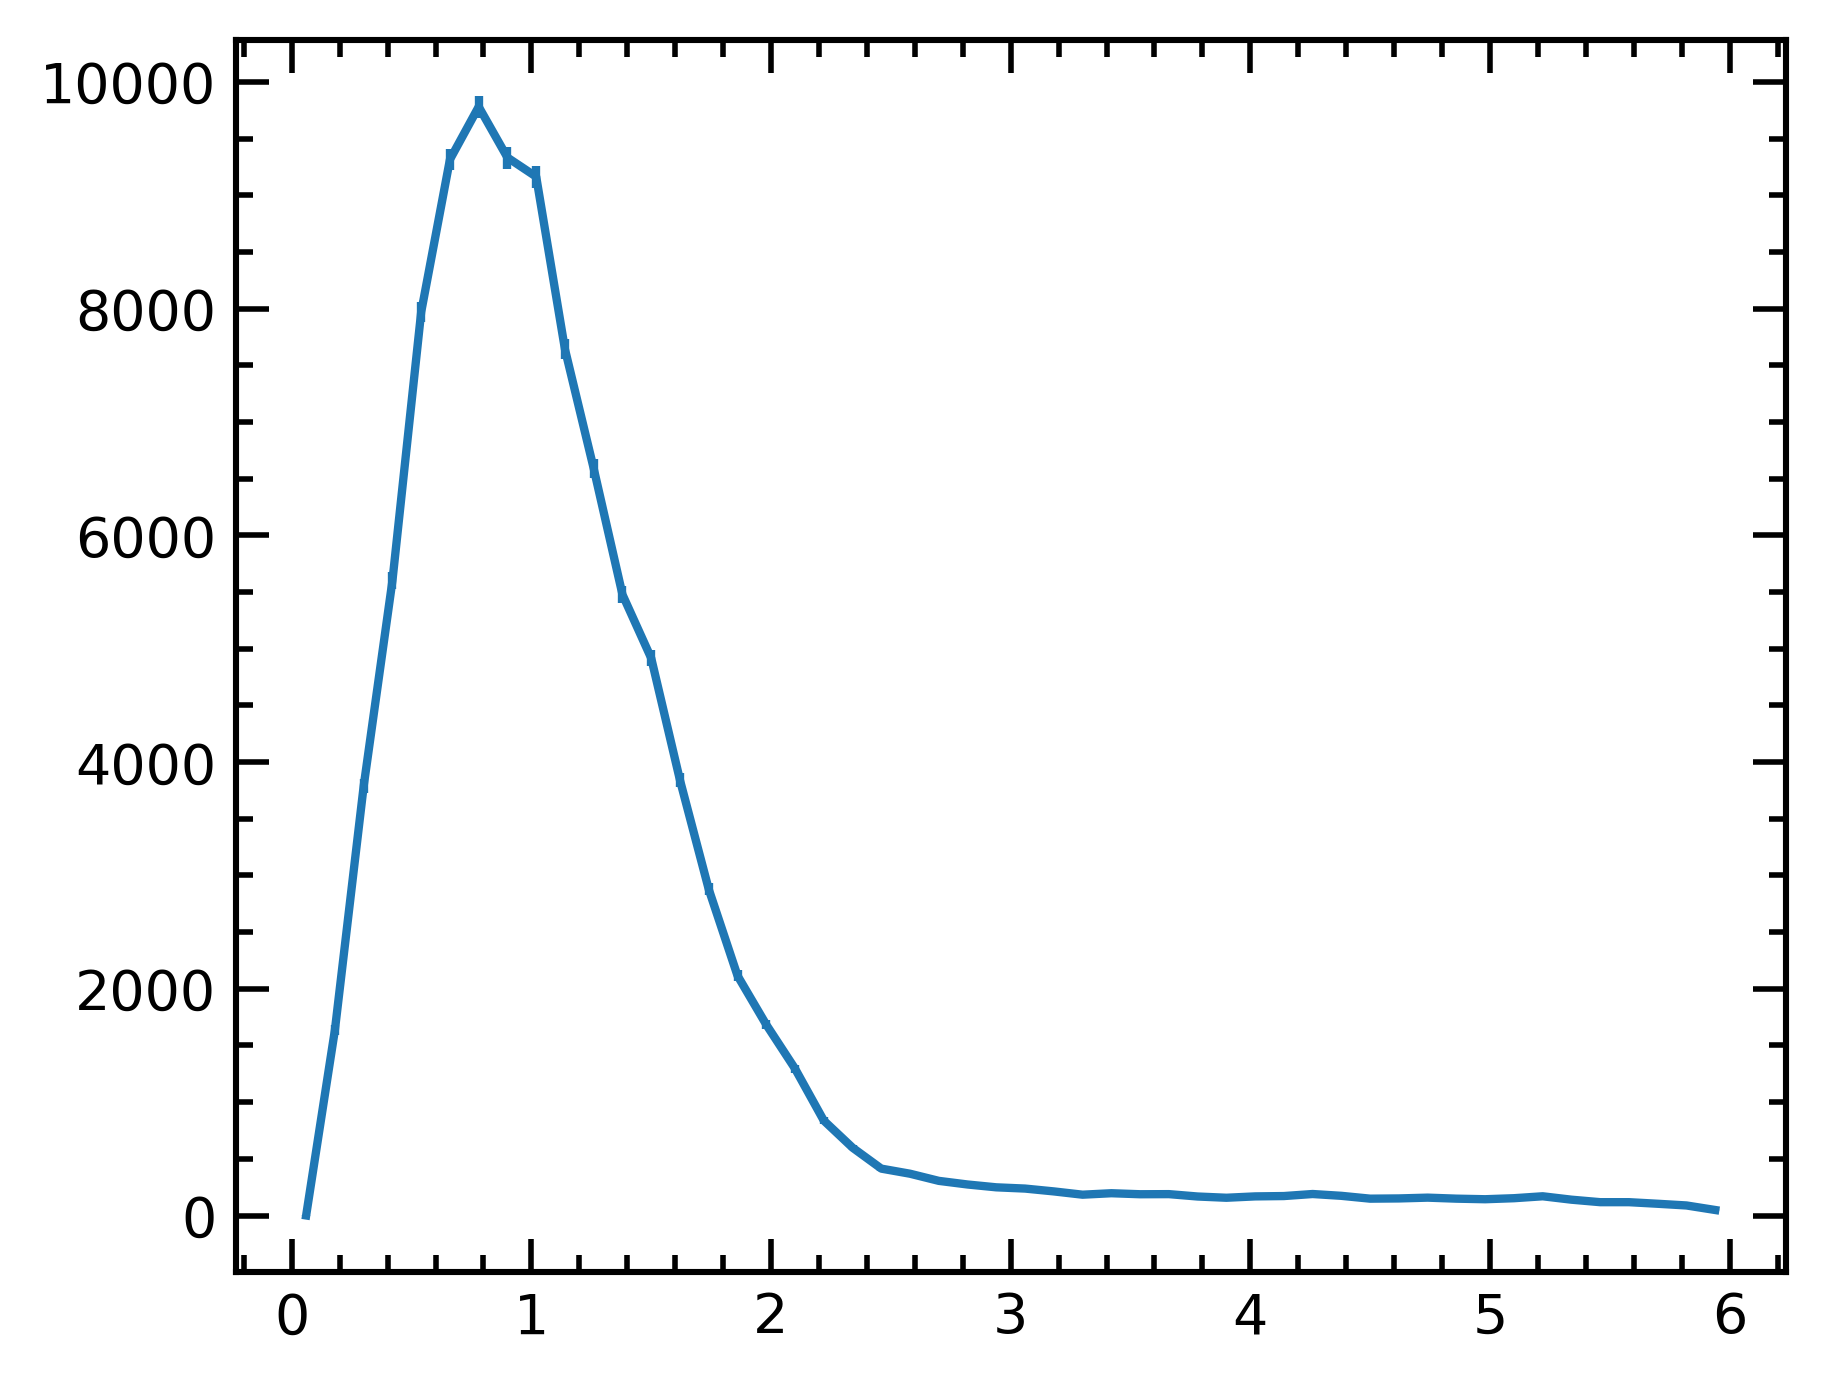

 -------------------------------------------------------
 | bin |   mc |   err |  CCQE |   err | NON-CCQE | err |
 -------------------------------------------------------
 |   0 |    1 |     1 |   0.3 |   0.3 |        0 |   0 |
 |   1 | 1637 | 40.46 | 491.1 | 12.14 |        0 |   0 |
 |   2 | 3787 | 61.54 |  1136 | 18.46 |        0 |   0 |
 |   3 | 5599 | 74.83 |  1680 | 22.45 |        0 |   0 |
 |   4 | 7969 | 89.27 |  2391 | 26.78 |        0 |   0 |
 |   5 | 9315 | 96.51 |  2795 | 28.95 |        0 |   0 |
 |   6 | 9780 | 98.89 |  2934 | 29.67 |        0 |   0 |
 |   7 | 9332 |  96.6 |  2800 | 28.98 |        0 |   0 |
 |   8 | 9163 | 95.72 |  2749 | 28.72 |        0 |   0 |
 |   9 | 7641 | 87.41 |  2292 | 26.22 |        0 |   0 |
 |  10 | 6589 | 81.17 |  1977 | 24.35 |        0 |   0 |
 |  11 | 5477 | 74.01 |  1643 |  22.2 |        0 |   0 |
 |  12 | 4916 | 70.11 |  1475 | 21.03 |        0 |   0 |
 |  13 | 3840 | 61.97 |  1152 | 18.59 |        0 |   0 |
 |  14 | 2878 | 53.65 | 863.4 |

In [4]:
import matplotlib.pyplot as plt
import numpy as np
pn.cern()

hf = pn.HistFrame(pn.Binning.lin_space(0,6,50, "E_{nu} [GeV]"), "mc")
hf2 = pn.HistFrame(pn.Binning.lin_spaceND([[0,2,100],[0.0,2,100]], 
                                         ["q0","q3"]), "mc")

ccqe_col = hf.add_column("CCQE")
nonccqe_col = hf.add_column("NON-CCQE")

ccqe_col = hf2.add_column("CCQE")

for i, (ev, cvw) in enumerate(evs):
    hf.fill(enu_GeV(ev),cvw)
    hf.fill(enu_GeV(ev),cvw*0.3*(pps.filter.proc_id(ev) < 300), ccqe_col)
    hf.fill(enu_GeV(ev),cvw*0.1*(pps.filter.proc_id(ev) > 300), nonccqe_col)
    
    if q0(ev) > 0:
        hf2.fill([q0(ev),q3(ev)],cvw*0.95)
    if i >= 1E5:
        break

plt.errorbar(pn.Binning.get_bin_centers1D(hf.binning.bins),
             hf.sumweights[:,0],yerr=np.sqrt(hf.variances[:,0]))
plt.show()

print(hf)


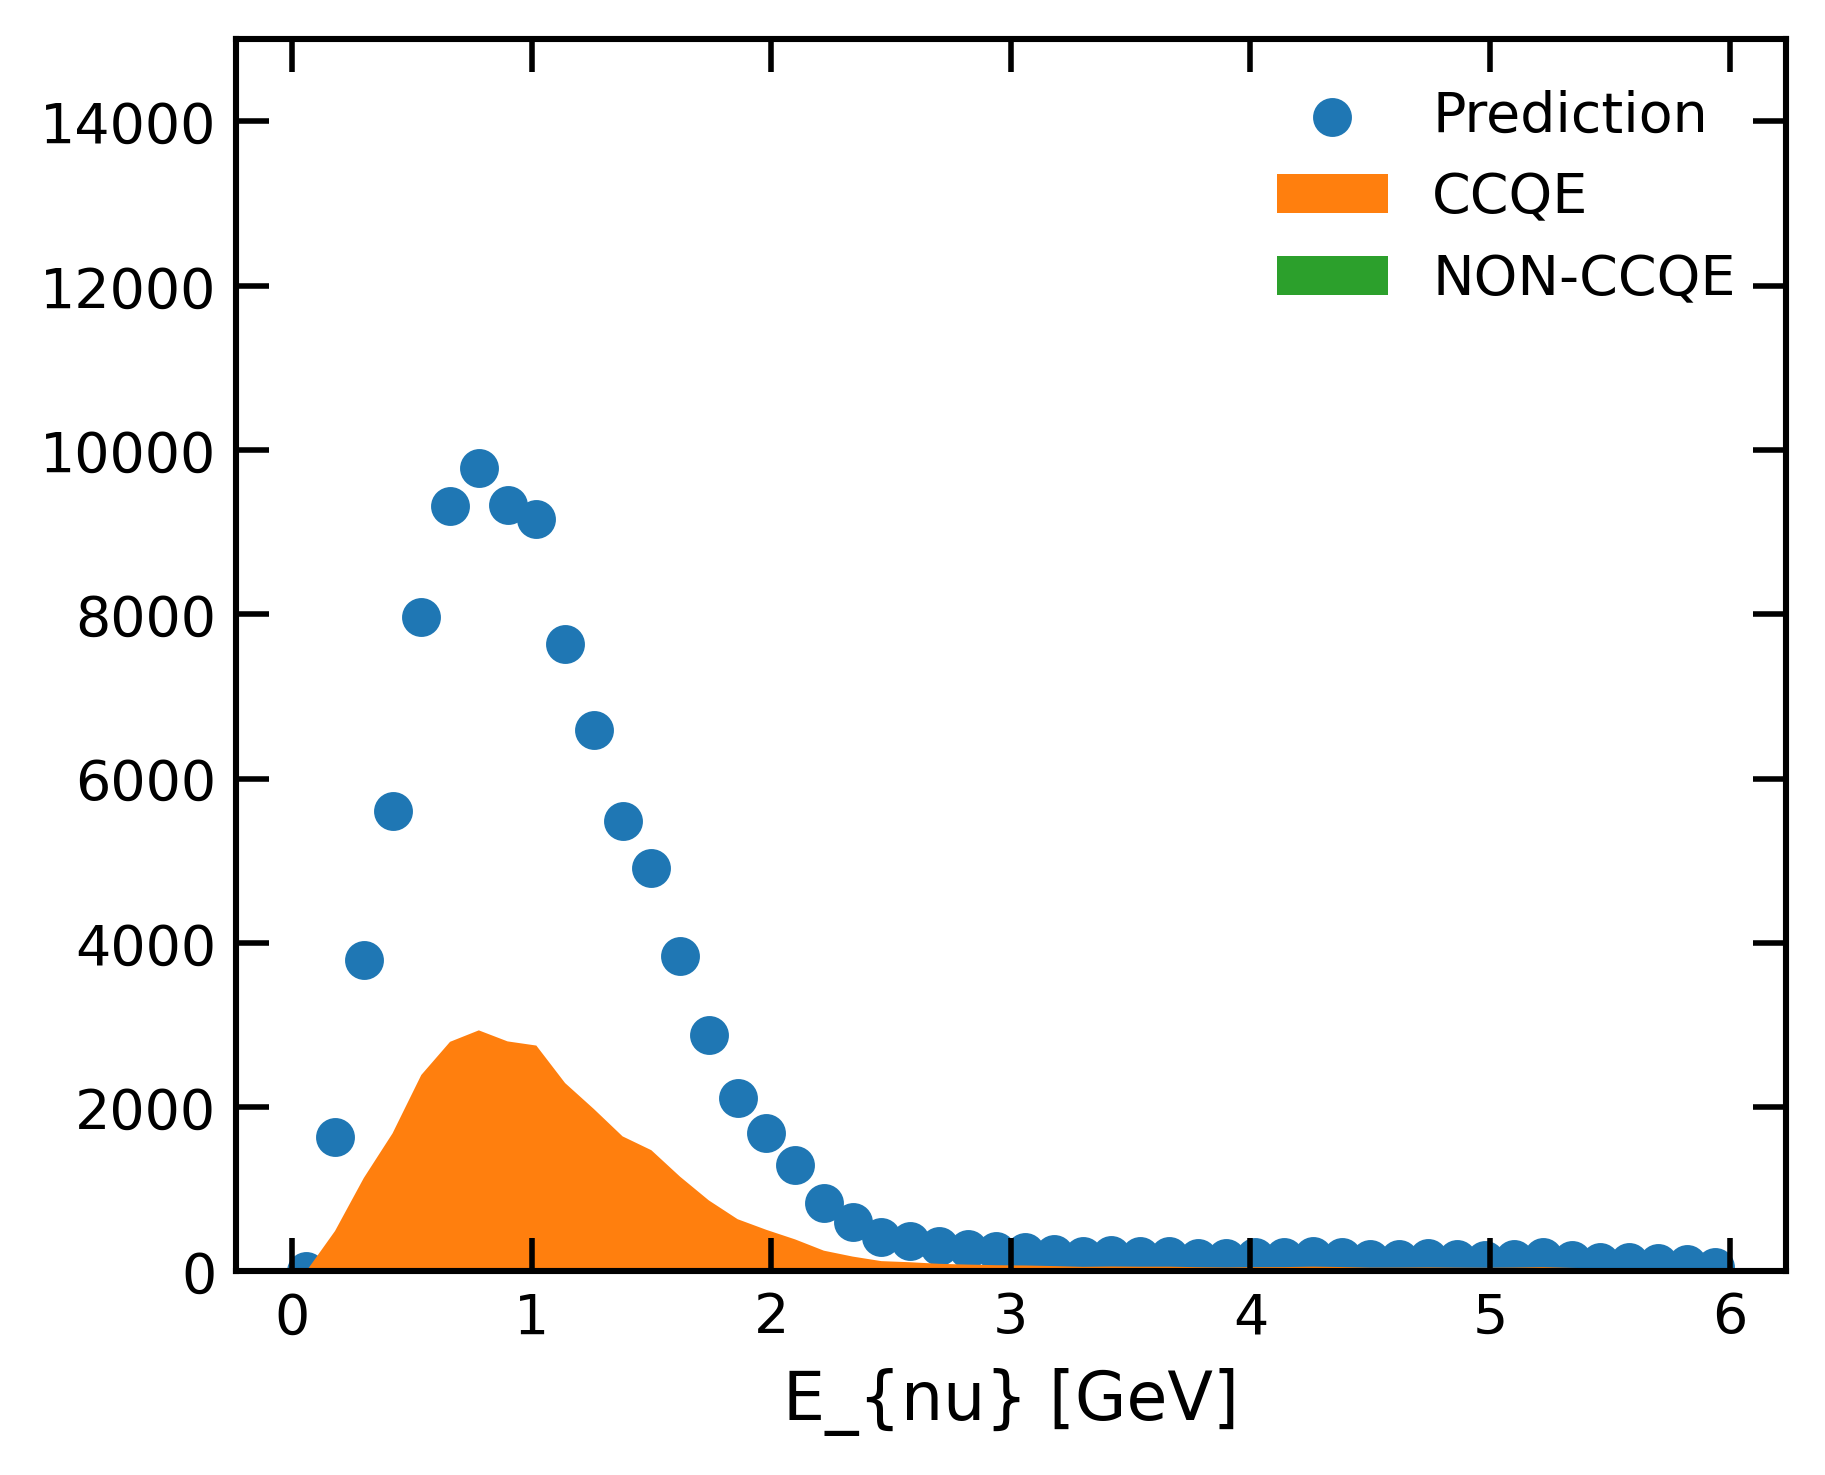

mc


In [5]:
hf.mpl().scatter(label="Prediction")
hf.mpl().fill_all(cols=["CCQE", "NON-CCQE"])
plt.ylim([0,15000])
plt.legend()
plt.show()
print(hf.column_info[0].name)

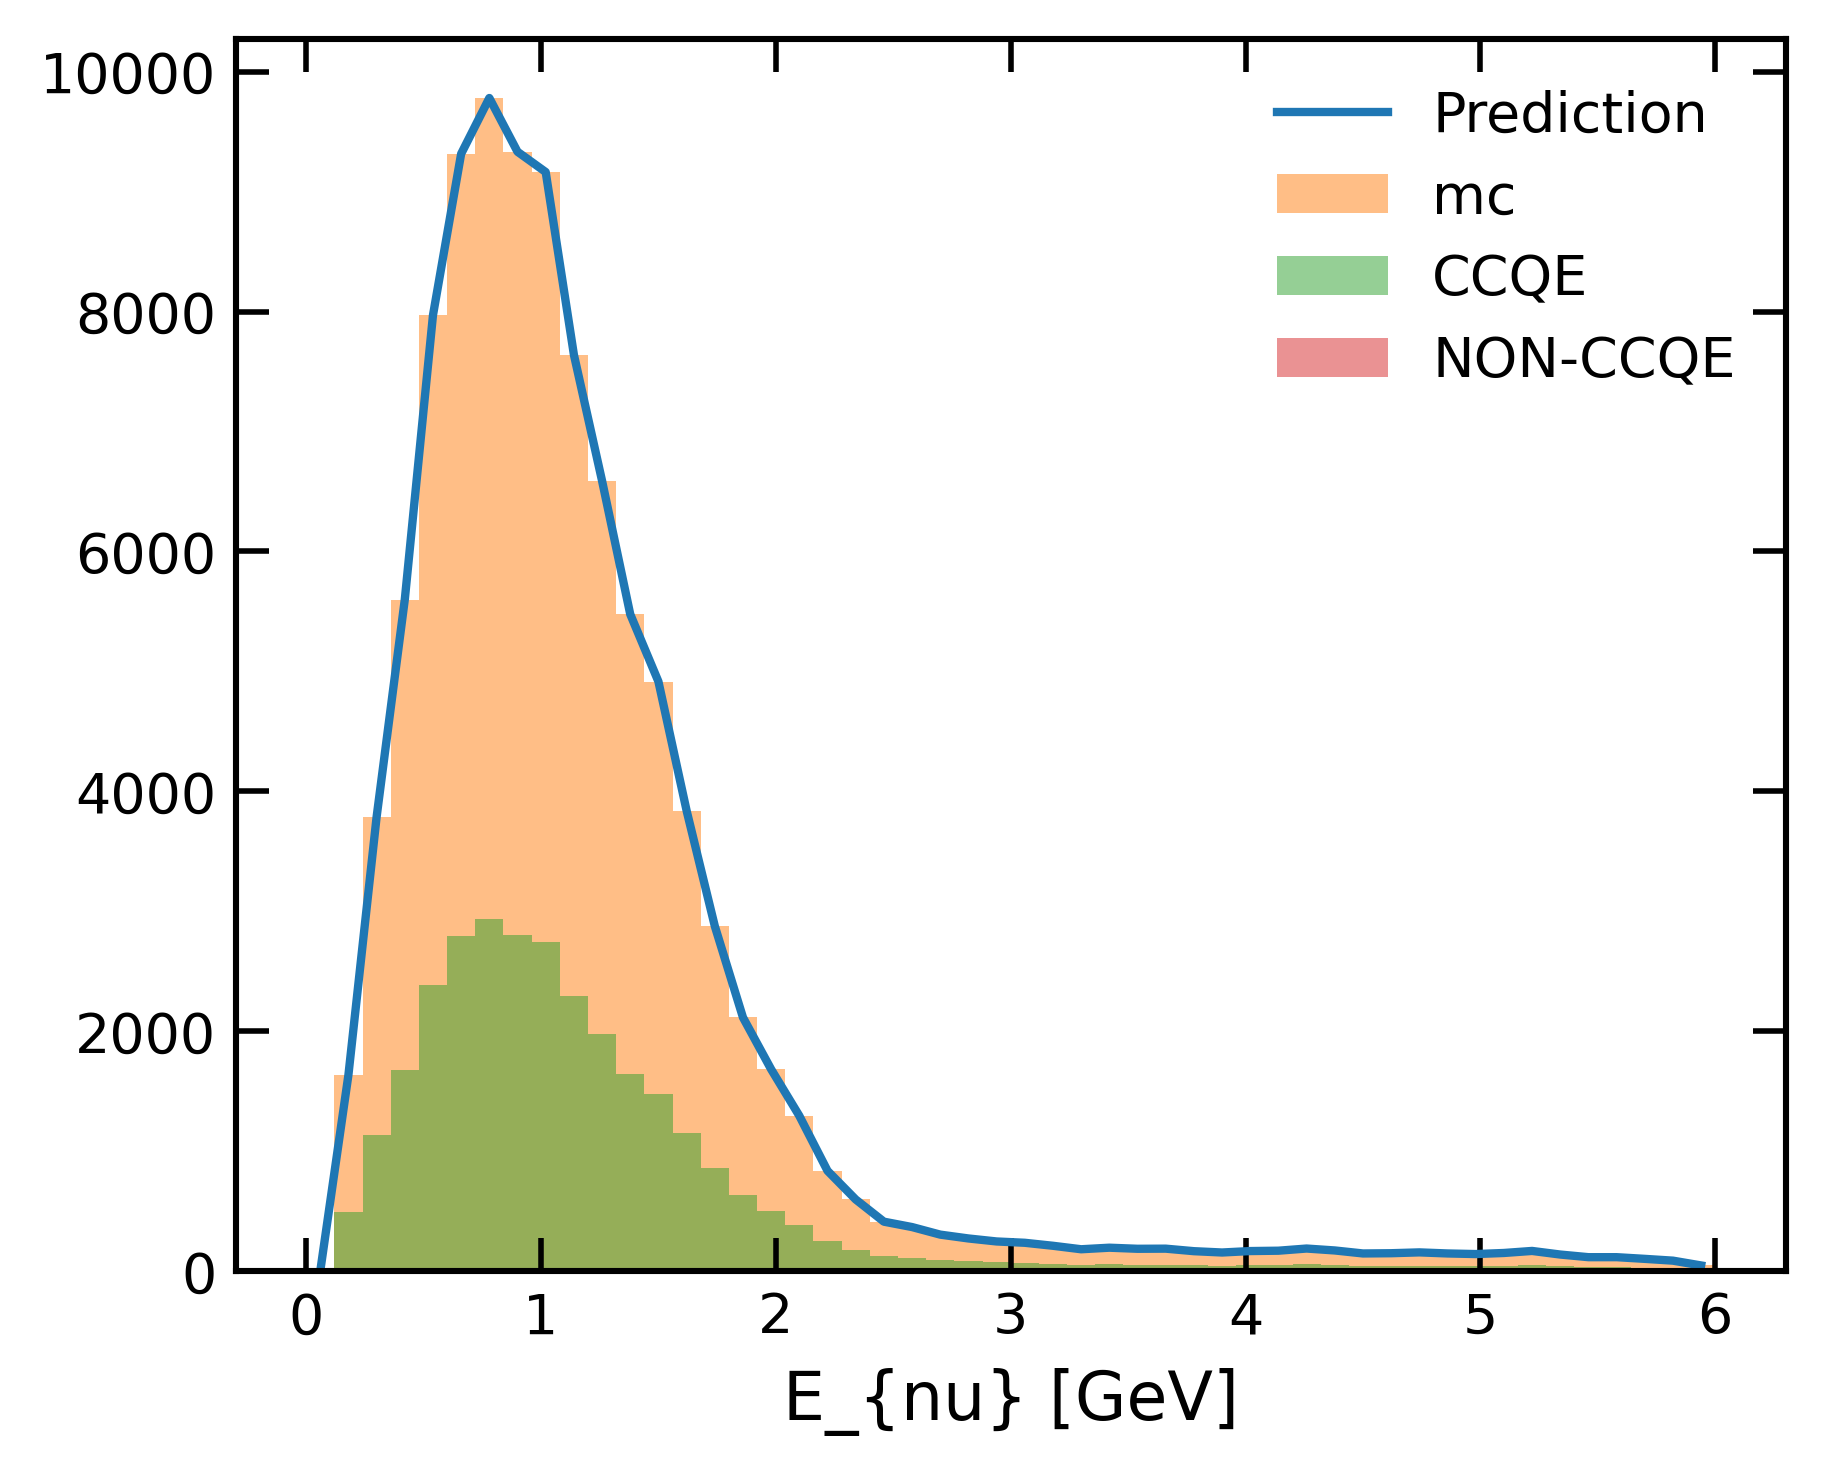

In [6]:
hf.mpl().plot(label="Prediction")
hf.mpl().hist_all(alpha=0.5)
plt.legend()
plt.show()

## 2D Histograms

As we saw in the [binning notebook](https://github.com/NUISANCEMC/eventinput/blob/main/notebooks/binning.ipynb), we can make multi-dimensional binnings. These can be used to instantiate `HistFrame`s.

In [7]:
hf_ptpz = pn.HistFrame(pn.Binning.lin_spaceND([[0,5,75],[0,1.25,25]], ["pz","pt"]))

In [8]:
def ptpz(ev):
    bpart = pps.sel.Beam(ev,14)
    if not bpart:
        return pn.Frame.missing_datum
    beam_pid = bpart.pid()
    cc_lep_pid = (beam_pid - 1) if (beam_pid > 0) else (beam_pid + 1);
    lep = pps.sel.OutPartHM(ev, int(cc_lep_pid))
    if not lep:
        return pn.Frame.missing_datum
    
    return [lep.momentum().pz() * 1E-3, lep.momentum().pt() * 1E-3]

In [9]:
hf_ptpz.reset()
for i, (ev, cvw) in enumerate(evs):
    ev_ptpz = ptpz(ev)
    if ev_ptpz != pn.Frame.missing_datum:
        hf_ptpz.fill(ev_ptpz,cvw)
    if i >= 1E6:
        break

print(hf_ptpz)

 --------------------
 | bin | mc |   err |
 --------------------
 |   0 | 96 | 9.798 |
 |   1 | 59 | 7.681 |
 |   2 | 48 | 6.928 |
 |   3 | 37 | 6.083 |
 |   4 | 25 |     5 |
 |   5 | 34 | 5.831 |
 |   6 | 28 | 5.292 |
 |   7 | 32 | 5.657 |
 |   8 | 23 | 4.796 |
 |   9 | 13 | 3.606 |
 |  10 | 21 | 4.583 |
 |  11 | 21 | 4.583 |
 |  12 | 12 | 3.464 |
 |  13 |  9 |     3 |
 |  14 | 15 | 3.873 |
 |  15 | 15 | 3.873 |
 |  16 |  6 | 2.449 |
 |  17 | 16 |     4 |
 |  18 |  7 | 2.646 |
 |  19 |  3 | 1.732 |
 |  20 |  5 | 2.236 |
 | ... |   ... |
 --------------------


Drawing a 2D histogram is a little more fiddly in matplotlib (or plotly for that matter)

From [numpy.histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) and [matplotlib.pyplot.pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html):

```
(X[i+1, j], Y[i+1, j])       (X[i+1, j+1], Y[i+1, j+1])
                      ●╶───╴●
                      │     │
                      ●╶───╴●
    (X[i, j], Y[i, j])       (X[i, j+1], Y[i, j+1])
```

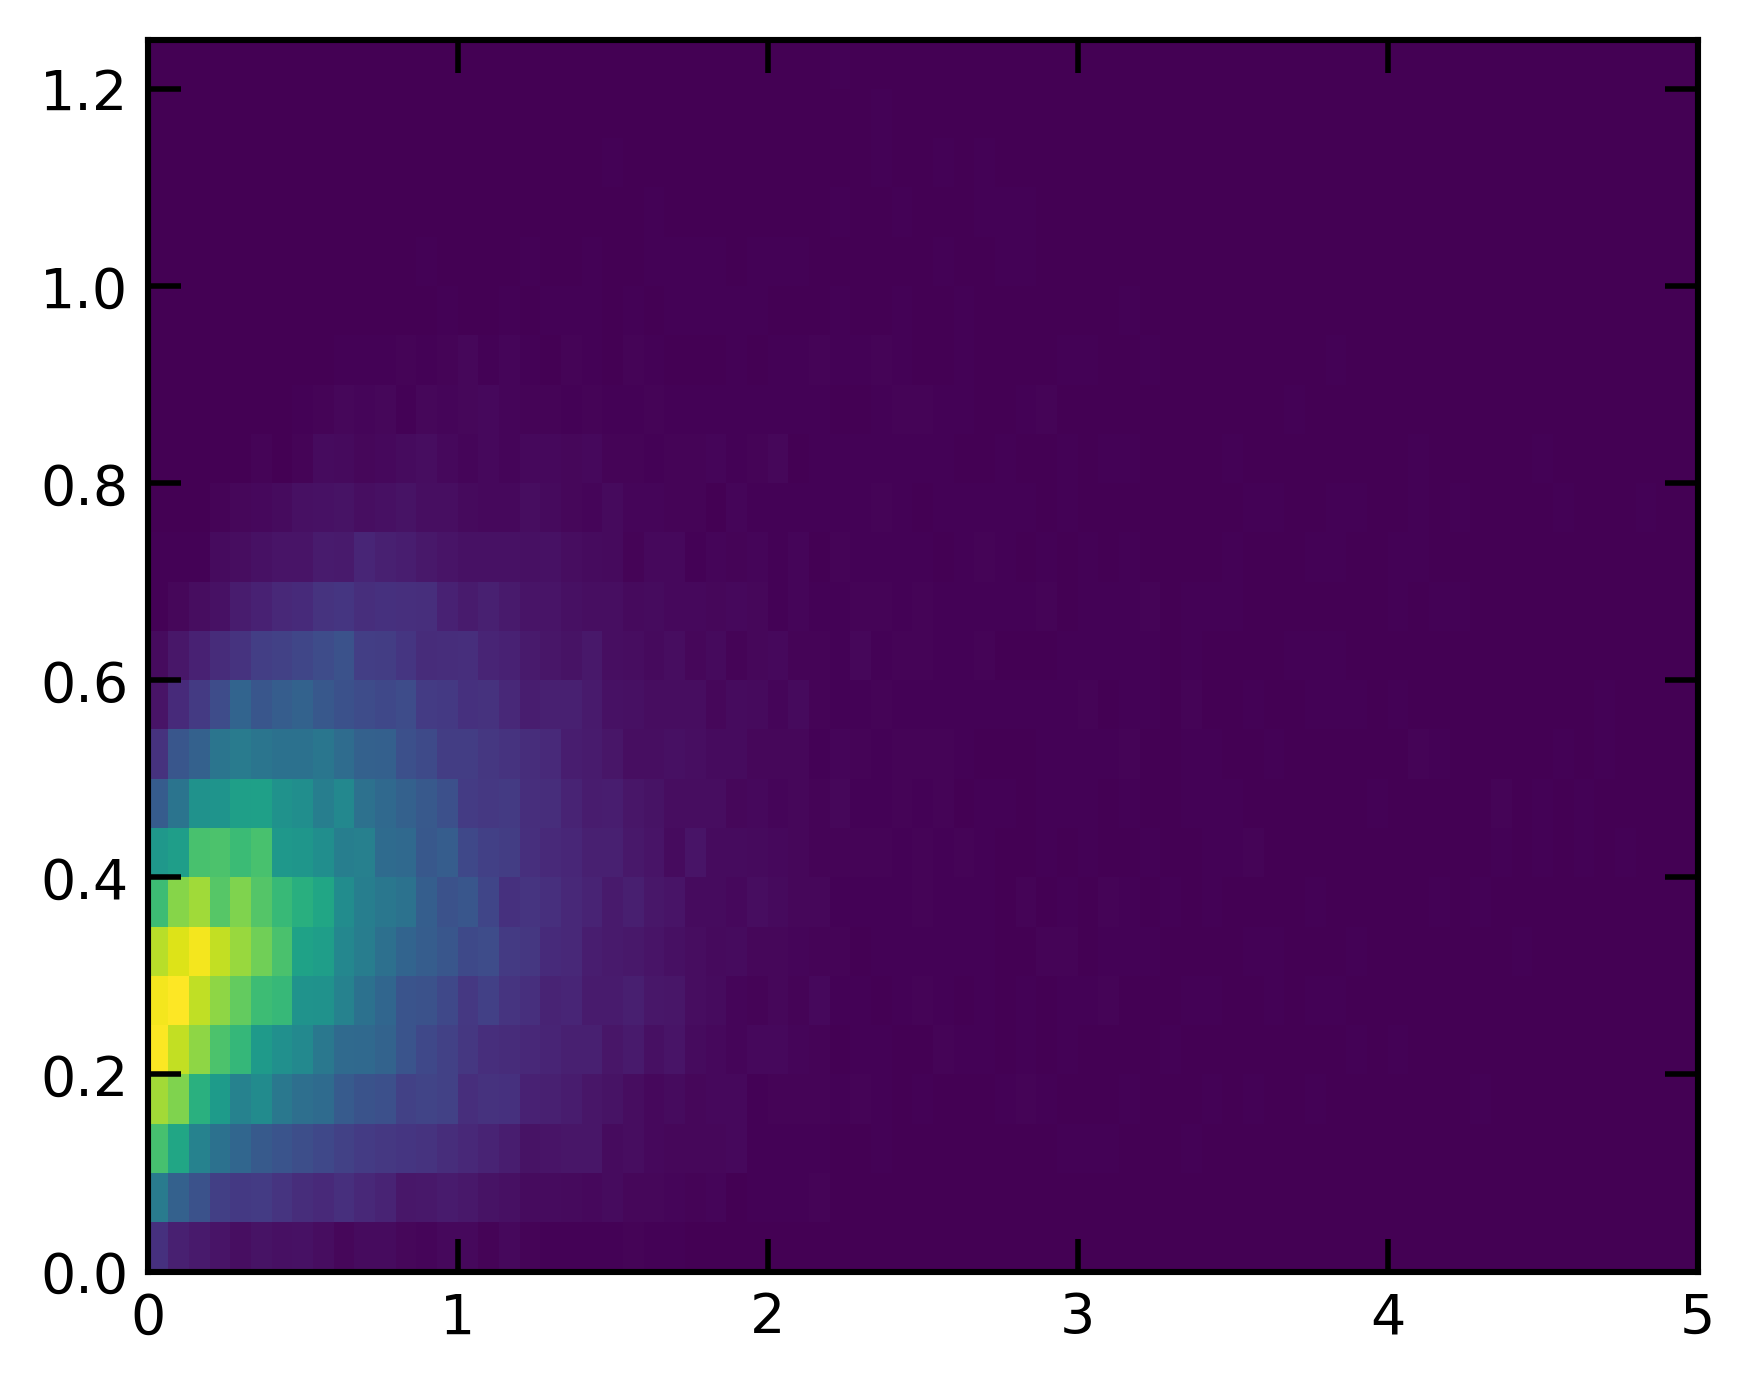

In [ ]:
# Automated helper
hf_ptpz.mpl().colormesh()
plt.show()

# Can't handle non normal shaped bins
hf_ptpz.mpl().hist2d()
plt.show()

we provide a helper function for building the pcolormesh data structures following the above logic

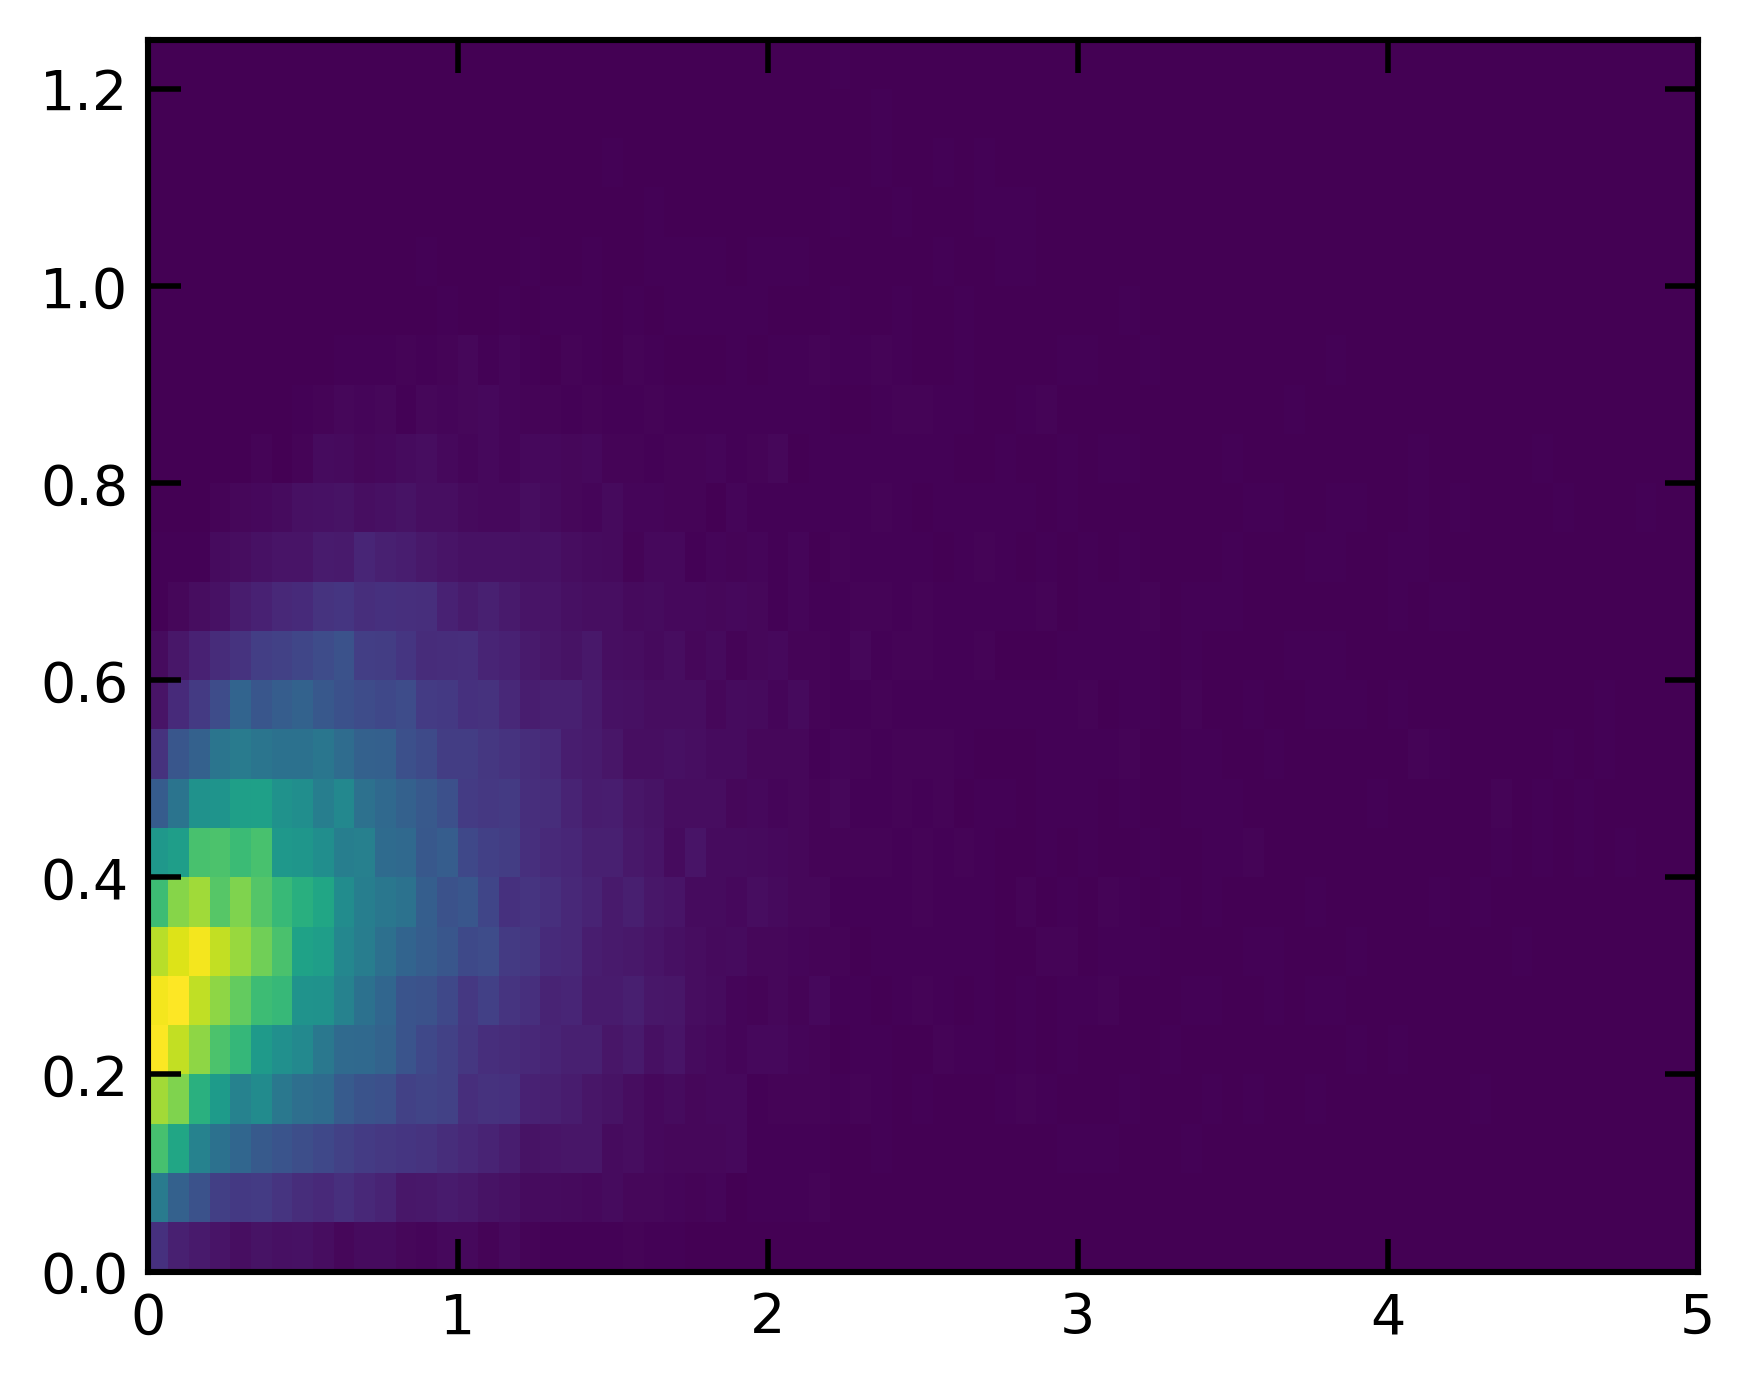

In [11]:
pcmdata = pn.convert.HistFrame.to_mpl_pcolormesh(hf_ptpz)
plt.pcolormesh(pcmdata["X"], pcmdata["Y"], pcmdata["C"])
plt.show()

## Projections
For rectangular binnings where projections onto lower dimensions are well defined, we can make histogram projections

In [12]:
hf_pt = pn.HistFrame.project(hf_ptpz,1)
print(hf_pt.binning)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

Axis lables: ["pt"]
Bins: [
  0: [(0.00 - 0.05)]
  1: [(0.05 - 0.10)]
  2: [(0.10 - 0.15)]
  3: [(0.15 - 0.20)]
  4: [(0.20 - 0.25)]
  5: [(0.25 - 0.30)]
  6: [(0.30 - 0.35)]
  7: [(0.35 - 0.40)]
  8: [(0.40 - 0.45)]
  9: [(0.45 - 0.50)]
  10: [(0.50 - 0.55)]
  11: [(0.55 - 0.60)]
  12: [(0.60 - 0.65)]
  13: [(0.65 - 0.70)]
  14: [(0.70 - 0.75)]
  15: [(0.75 - 0.80)]
  16: [(0.80 - 0.85)]
  17: [(0.85 - 0.90)]
  18: [(0.90 - 0.95)]
  19: [(0.95 - 1.00)]
  20: [(1.00 - 1.05)]
  21: [(1.05 - 1.10)]
  22: [(1.10 - 1.15)]
  23: [(1.15 - 1.20)]
  24: [(1.20 - 1.25)]
]

 ----------------------
 | bin |   mc |   err |
 ----------------------
 |   0 |  563 | 23.73 |
 |   1 | 1937 | 44.01 |
 |   2 | 3516 |  59.3 |
 |   3 | 5013 |  70.8 |
 |   4 | 6111 | 78.17 |
 |   5 | 6969 | 83.48 |
 |   6 | 7492 | 86.56 |
 |   7 | 7151 | 84.56 |
 |   8 | 6263 | 79.14 |
 |   9 | 5284 | 72.69 |
 |  10 | 4140 | 64.34 |
 |  11 | 3070 | 55.41 |
 |  12 | 2219 | 47.11 |
 |  13 | 1529 |  39.1 |
 |  14 |  900 |    30

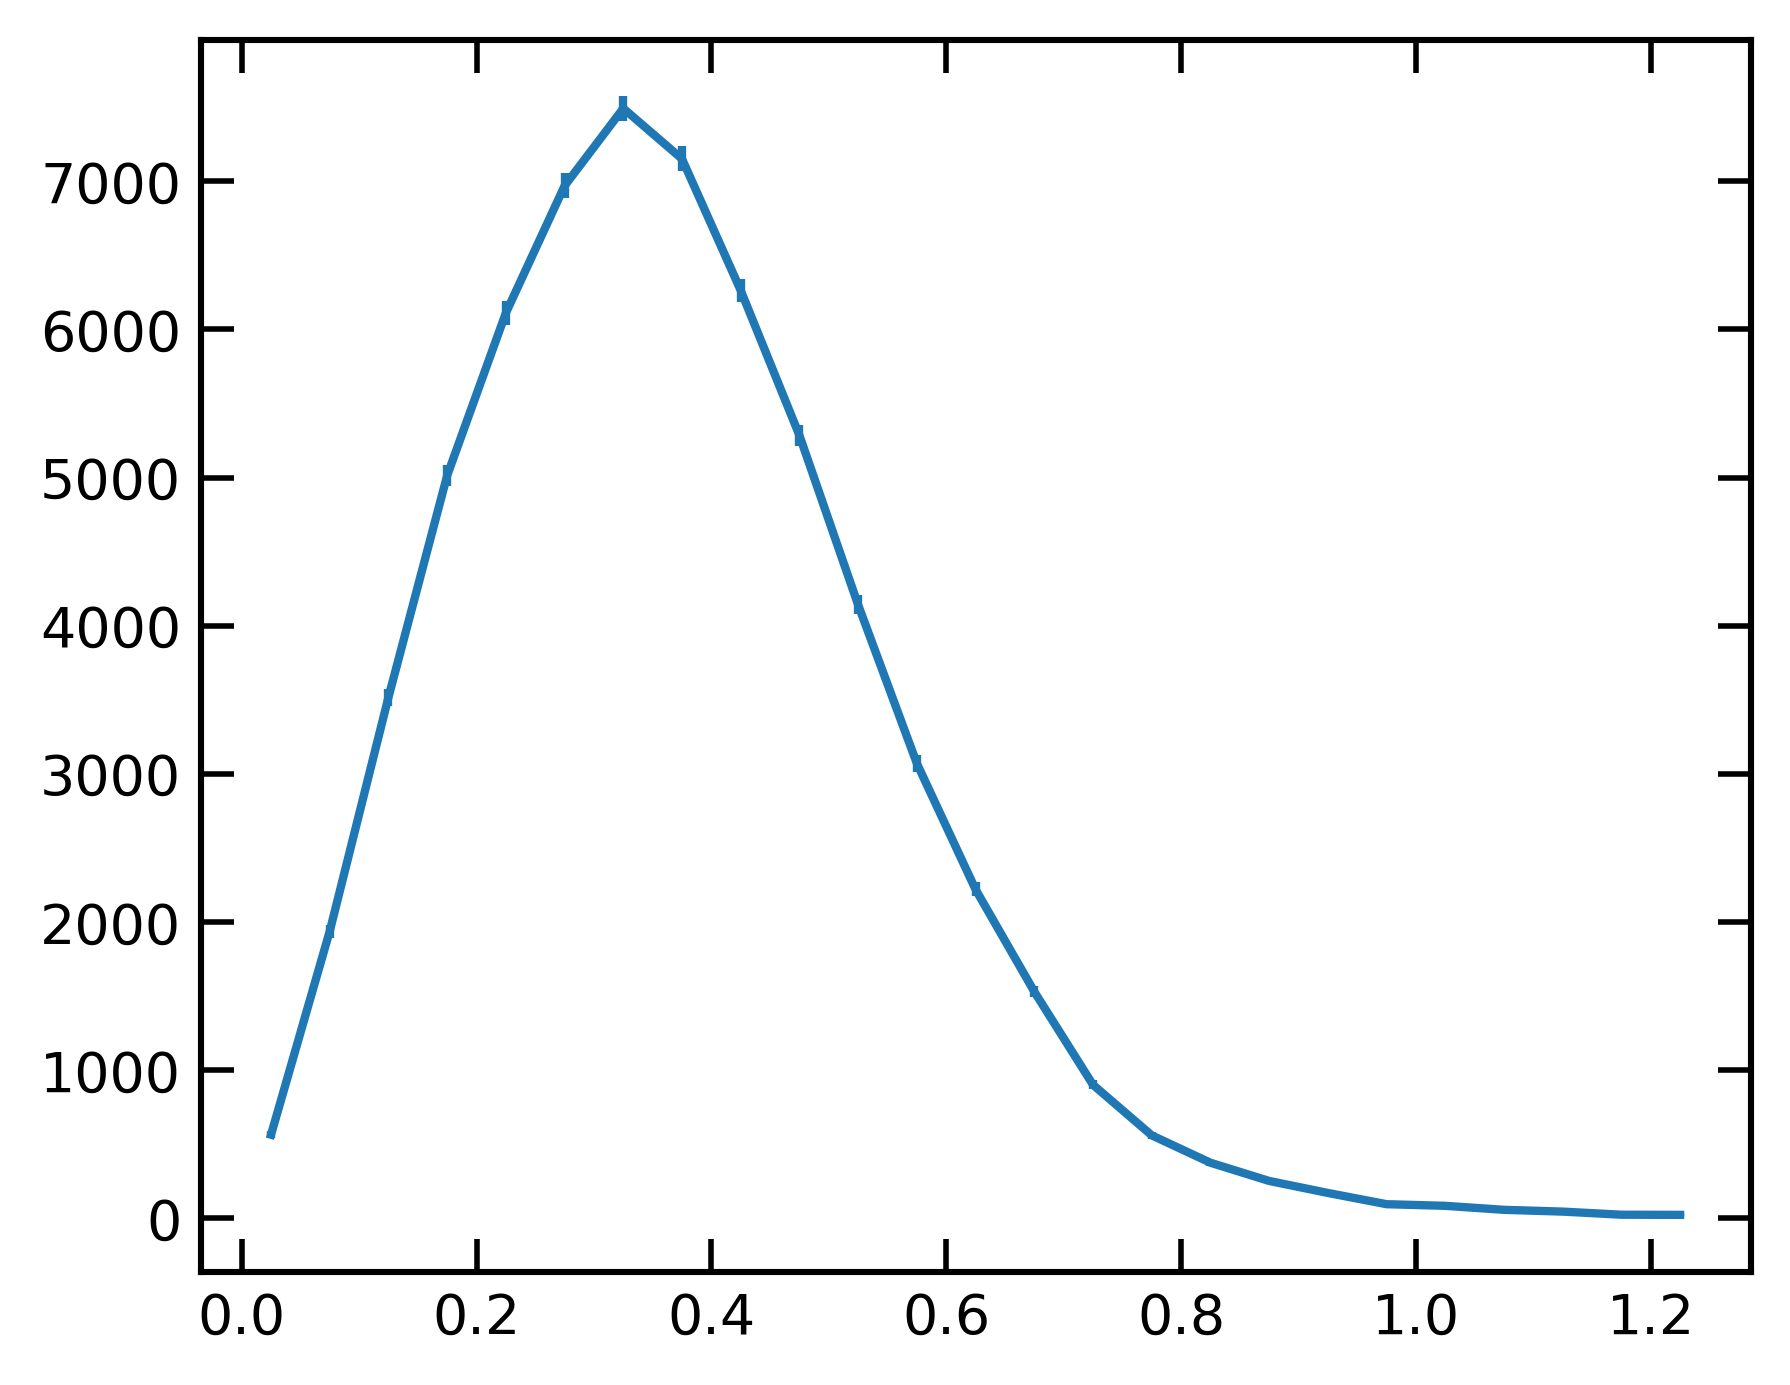

In [13]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()

While it is unlikely that we would want to continue calling fill on a projection histogram, it is supported.

In [14]:
hf_pt.fill(0.5,10000)
print(hf_pt)
print("nfills: %s" % hf_pt.nfills)

 ---------------------------
 | bin |        mc |   err |
 ---------------------------
 |   0 |       563 | 23.73 |
 |   1 |      1937 | 44.01 |
 |   2 |      3516 |  59.3 |
 |   3 |      5013 |  70.8 |
 |   4 |      6111 | 78.17 |
 |   5 |      6969 | 83.48 |
 |   6 |      7492 | 86.56 |
 |   7 |      7151 | 84.56 |
 |   8 |      6263 | 79.14 |
 |   9 |      5284 | 72.69 |
 |  10 | 1.414e+04 | 1e+04 |
 |  11 |      3070 | 55.41 |
 |  12 |      2219 | 47.11 |
 |  13 |      1529 |  39.1 |
 |  14 |       900 |    30 |
 |  15 |       559 | 23.64 |
 |  16 |       374 | 19.34 |
 |  17 |       251 | 15.84 |
 |  18 |       170 | 13.04 |
 |  19 |        94 | 9.695 |
 |  20 |        83 |  9.11 |
 |       ... |   ... |
 ---------------------------
nfills: {}


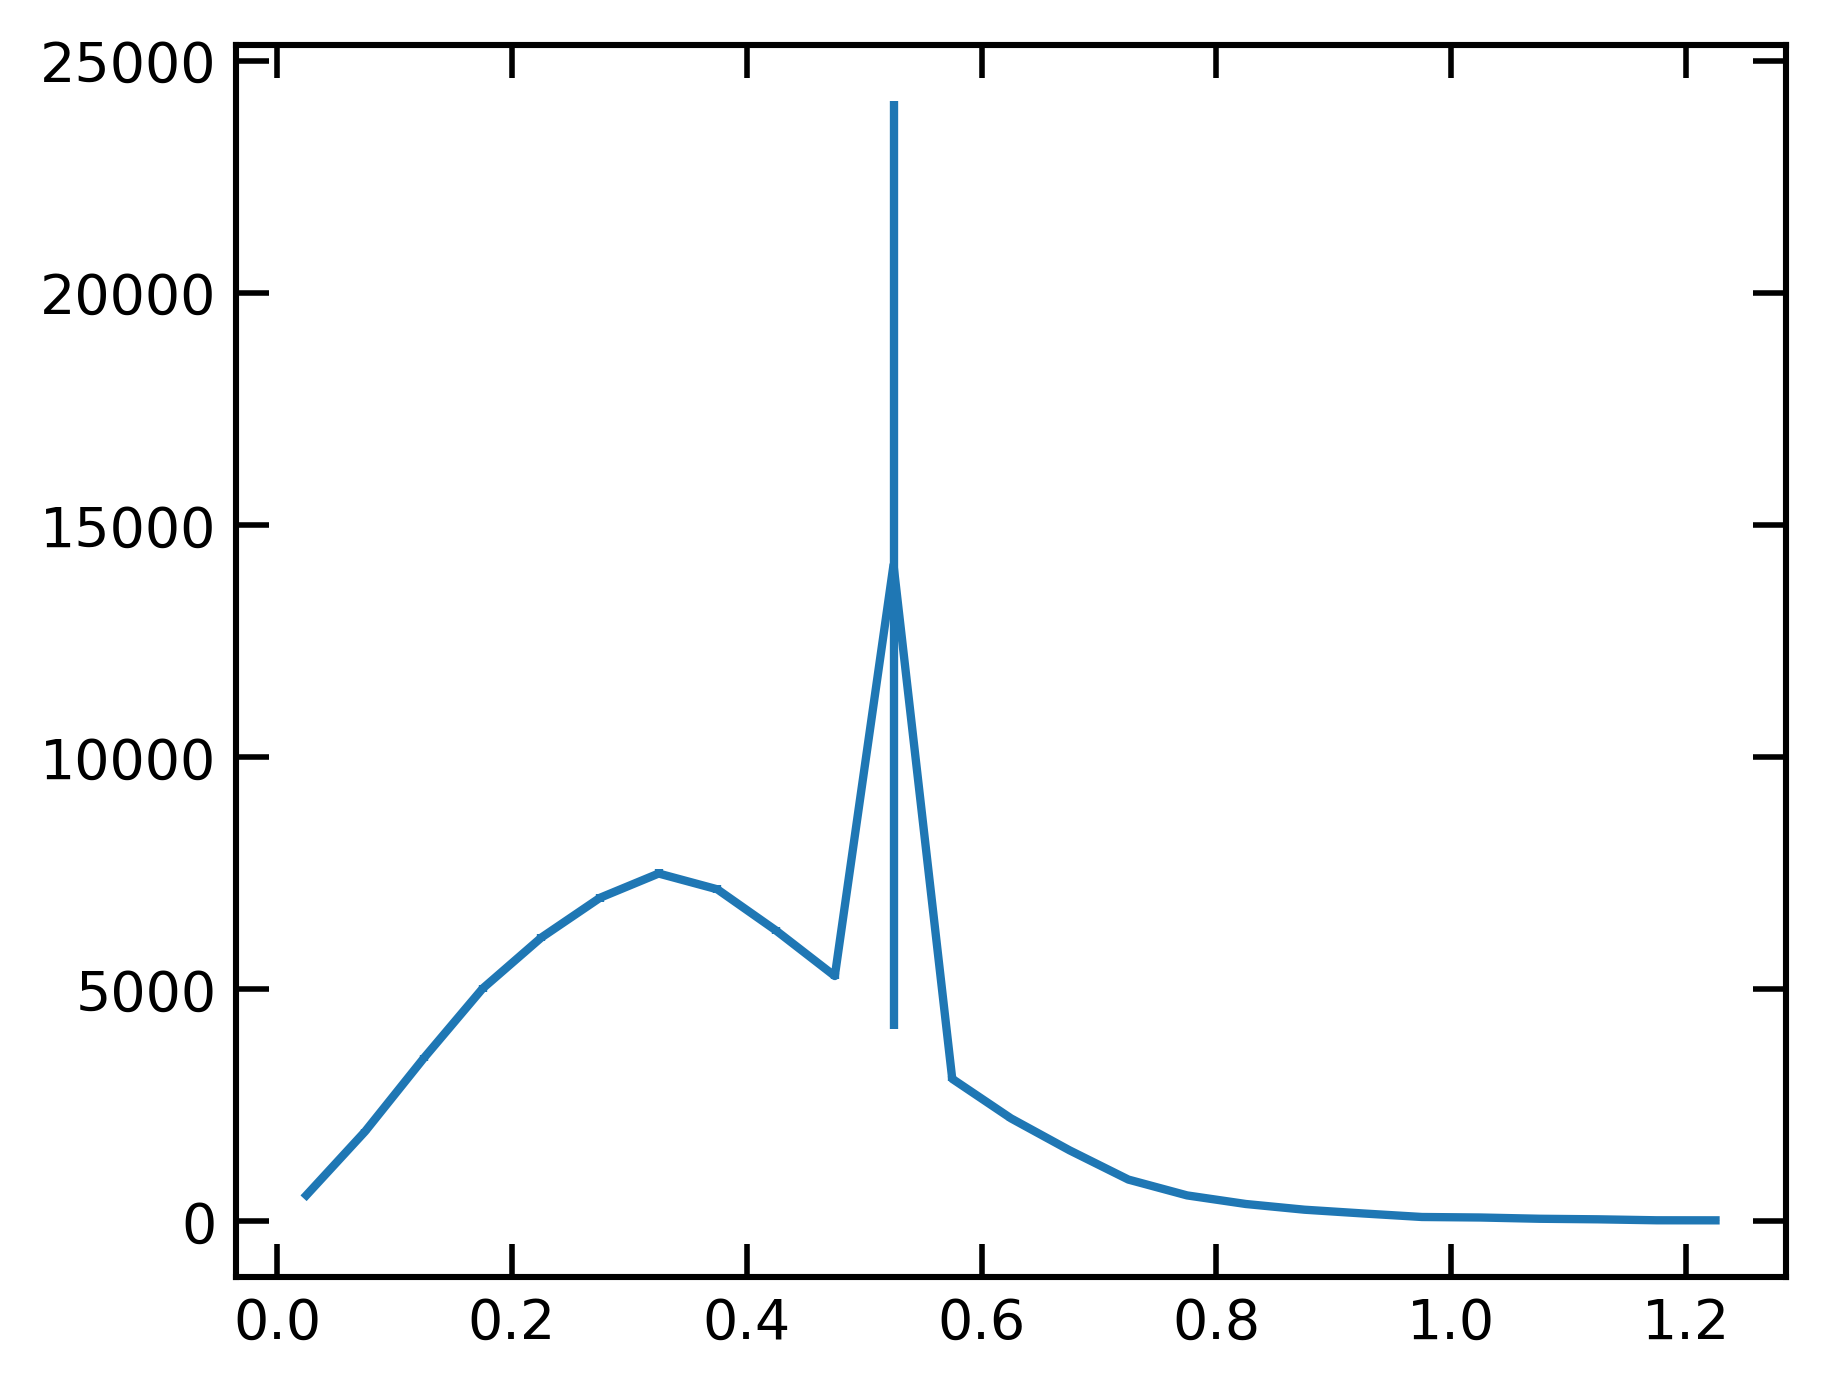

In [15]:
plt.errorbar(pn.Binning.get_bin_centers1D(hf_pt.binning.bins),
             hf_pt.sumweights[:,0],yerr=np.sqrt(hf_pt.variances[:,0]))
plt.show()